# <center> Сегментация клиентов онлайн магазина подарков

Импорт базовых библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## 1. Знакомство с данными

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* `InvoiceNo` — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* `StockCode` — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* `Description` — название товара;
* `Quantity` — количество каждого товара за транзакцию;
* `InvoiceDate` — дата и время выставления счёта/проведения транзакции;
* `UnitPrice` — цена за единицу товара в фунтах стерлингов;
* `CustomerID` — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* `Country` — название страны, в которой проживает клиент.

#### Важные замечания:

- В заказе может быть указано отрицательное количество товара (`Quantity` < 0). Как правило, это свидетельствует о возврате товара, но также может означать скидки.

- Номер заказа (`InvoiceNo`) может содержать не только числа, но и символы. \
    Например, символ '**C**' перед номером заказа указывает на признак возврата. То есть в таблице должна находиться запись с такими же идентификаторами клиента и товара, но номером заказа без символа '**C**' и с положительным количеством товара.

- Код товара (`StockCode`) также может содержать не только числа, но и символы. \
    Например, '**D**' означает, что товар является скидочным и на такие товары нет аналогов с положительным числом товаров в заказе.

- Однако не все заказы с отрицательным количеством товара имеют в таблице свои аналоги (контрагентов). Например, заказ на покупку товара от клиента поступил раньше декабря 2010 года, а возрат поступил после, что выходит за диапазон наших данных.

- Клиент может отменить не весь заказ, а только его часть 

In [2]:
# Загрузим наш датасет
data = pd.read_csv(
    'data/data.csv', 
    encoding='ISO-8859-1', 
    dtype={'CustomerID': str,'InvoiceID': str}
)

print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [4]:
# Изменим формат даты на datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Выведем временной интервал, в котором совершались транзакции
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


In [5]:
# Посмотрим на статистические характеристики в наших данных
display(data.describe(include='all'))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,NaN,NaN


Наши данные ограничиваются интервалом с *2010-12-01* по *2011-12-09*. Подавляющее число заказов приходится на Великобританию, так же стоит обратить внимание на возможные выбросы в признаках `Quantity` и `UnitPrice`.

In [6]:
# Посмотрим на уникальные страны в наших данных
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

#### 1.1. Проверим данные на пропуски

In [7]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Пропуски в столбце с идентификатором клиента (`CustomerID`) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях, поэтому удалим их.

In [8]:
# Удаляем строки с пропусками по столбцу 'CustomerID'
data.dropna(subset=['CustomerID'], inplace=True)
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Как видим, пропуски в названиях товаров (`Description`) тоже удалились, что не может не радовать.

#### 1.2. Проверим данные на наличие дубликатов

In [9]:
print('Количество дубликатов: {}'.format(data.duplicated().sum()))

Количество дубликатов: 5225


In [10]:
# Удалим их
data = data.drop_duplicates()

#### 1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [11]:
temp = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns={'InvoiceDate': 'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [12]:
nb_products_per_basket['Number of products'].value_counts()

Number of products
1      3400
2      1471
3      1028
4       776
5       766
       ... 
190       1
179       1
202       1
148       1
164       1
Name: count, Length: 197, dtype: int64

Создадим новый признак `QuantityCanceled`. Он будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом.

In [13]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(shape=data.shape[0]), index=data.index)
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    # Осуществим перебор всех строк с возвратами
    for index, row in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == row['CustomerID']) &
                       (data['StockCode'] == row['StockCode']) &
                       (data['InvoiceDate'] < row['InvoiceDate']) &
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if df_test.shape[0] == 0:
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled
        elif df_test.shape[0] == 1:
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -row['Quantity']
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif df_test.shape[0] > 1:
            df_test.sort_index(axis=0, ascending=False, inplace=True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -row['Quantity']:
                    continue
                quantity_canceled.loc[ind] = -row['Quantity']
                break
    return quantity_canceled

# Создадим новый признак QuantityCanceled
data['QuantityCanceled'] = get_quantity_canceled(data)

Посмотрим на количество транзакции, у которых отсутствуют контрагенты. Если их мало, то просто избавимся от них.

In [14]:
# Найдем процент транзакций, не имеющих контрагентов
print('Процент отсутствующих контрагентов: {:.2f}%'.format(data['QuantityCanceled'].isna().sum() / data.shape[0] * 100))

Процент отсутствующих контрагентов: 0.32%


In [15]:
# Удалим пропуски и избавимся от отрицательных значений в 'Quantity'
data = data[data['Quantity'] >= 0].dropna()

#### 1.4. Специализированные транзакции

Обработаем специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций, которые начинаются с латинских букв (при этом коды могут содержать цифры), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны.

In [16]:
# Избавимся от строк, где 'StockCode' начинается с латинской буквы
data = data[~data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]

#### 1.5. Транзакции с товарами без стоимости

In [17]:
# Посмотрим на количество товаров без стоимости
print('Кол-во товаров без стоимости: {}'.format(len(data[data['UnitPrice'] == 0])))

Кол-во товаров без стоимости: 33


In [18]:
# Избавимся от них
data = data[data['UnitPrice'] != 0]

#### 1.6. Общая стоимость товаров в транзакции

Создадим новый признак `TotalPrice`, который будет отражать общую стоимость товаров.

In [19]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
data['TotalPrice'].sort_values()

74840      -81.00
5246       -72.25
24097      -39.10
25483      -33.60
440083     -31.20
           ...   
244419    4401.00
160542    4632.00
421601    4992.00
160546    6539.40
348325    7144.72
Name: TotalPrice, Length: 391150, dtype: float64

Отрицательные значения в признаке являются случаем, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). Таких случаев очень мало, поэтому удалим их.

In [20]:
data = data[data['TotalPrice'] > 0]

#### 1.7. Признаки даты и времени

Дата и время являются важными аспектами при анализе клиентов, поэтому выжмем максимум из признака `InvoiceDate`.

In [21]:
data['Month'] = data['InvoiceDate'].dt.month # месяц
data['Day'] = data['InvoiceDate'].dt.day # день
data['DayOfWeek'] = data['InvoiceDate'].dt.day_of_week # день недели
data['Hour'] = data['InvoiceDate'].dt.hour # час

#### 1.8. Популярность товара

Создадим новый бинарный признак, отражающий популярность товара. \
Будем считать товар популярным, если его купили более 500 раз.

In [22]:
num_of_goods = data['Description'].value_counts()
goods_list = num_of_goods[num_of_goods >= 500].index.tolist() # список с популярными товарами

data['IsPopular'] = data['Description'].apply(lambda x: 1 if x in goods_list else 0) # 1 - товар есть в списке, 0 - отсутствует

#### 1.9. Сохранение преобразованного датасета.

In [ ]:
# # Сбросим индексы
# data.reset_index(drop=True, inplace=True)
# # Сохраним датасет в формате .csv
# data.to_csv('data/clients_clustering_upd.csv', index=False)

### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



Посмотрим на местоположение клиентов и сделаем вывод о самых популярных странах, из которых осуществляются заказы.

In [2]:
# Загрузим преобразованные данные
df = pd.read_csv('data/clients_clustering_upd.csv')

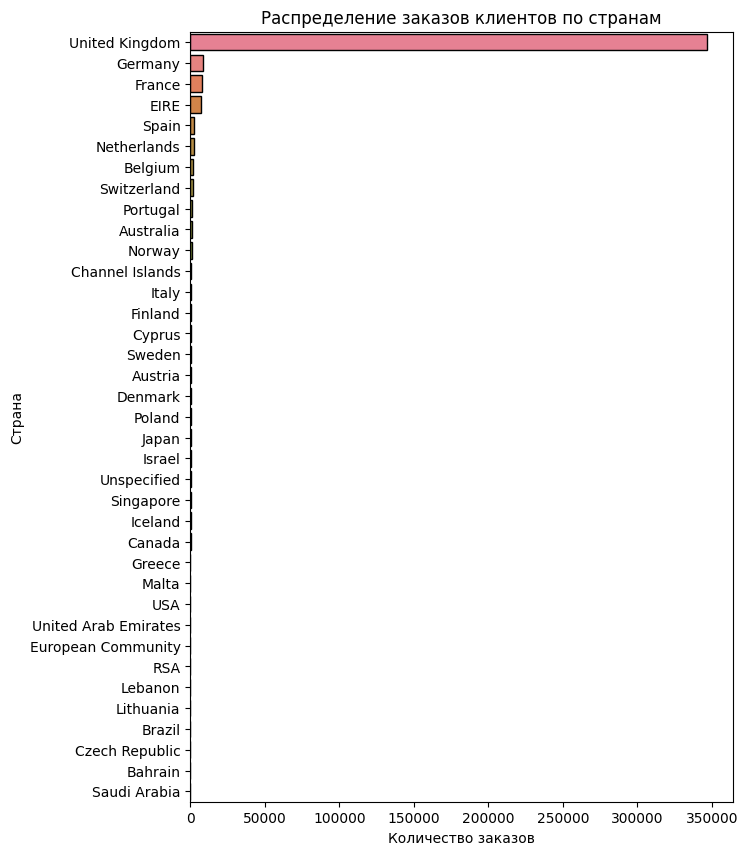

In [3]:
# Группируем данные по странам и считаем количество уникальных записей по клиентам для каждой страны
countries = df.groupby('Country', as_index=False)['CustomerID'].count()

# Визуализируем распределение заказов клиентов по странам
fig = plt.figure(figsize=(7, 10))
ax = sns.barplot(
    countries.sort_values(by='CustomerID', ascending=False), # сортировка по клиентам по убыванию
    x='CustomerID',
    y='Country',
    hue='Country',
)

ax.set_title('Распределение заказов клиентов по странам');
ax.set_xlabel('Количество заказов');
ax.set_ylabel('Страна');

Практически все клиенты совершали заказы из Великобритании.

Узнаем, зависят ли продажи от месяца.

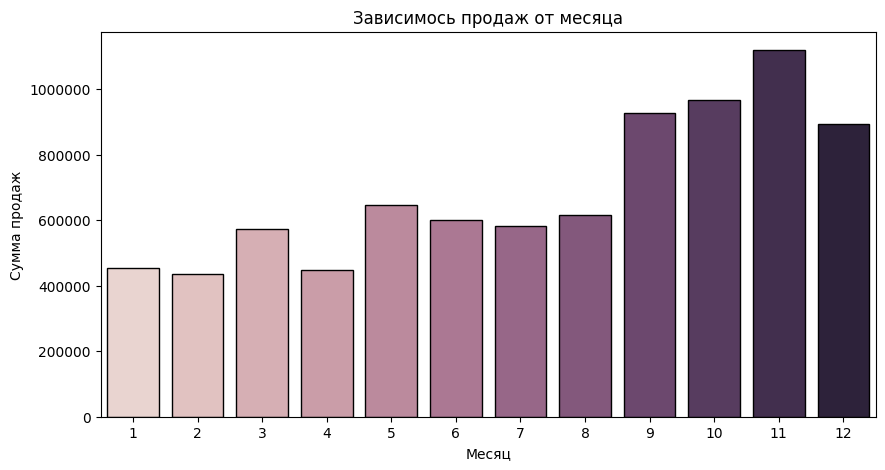

In [4]:
# Группируем данные по месяцам и считаем общую сумму продаж для каждого месяца
season_sells = df.groupby('Month', as_index=False)['TotalPrice'].sum()

# Визуализируем зависимость продаж от месяца
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(
    season_sells,
    x='Month',
    y='TotalPrice',
    hue='Month'
)

ax.set_title('Зависимось продаж от месяца');
ax.set_xlabel('Месяц');
ax.set_ylabel('Сумма продаж');
ax.legend_.remove();

# Уберем экспоненциальную запись в признаке 'TotalPrice'
plt.ticklabel_format(style='plain', axis='y')

Пик продаж приходится на *сентябрь-декабрь*.

Теперь узнаем средний чек в зависимости от дня недели.

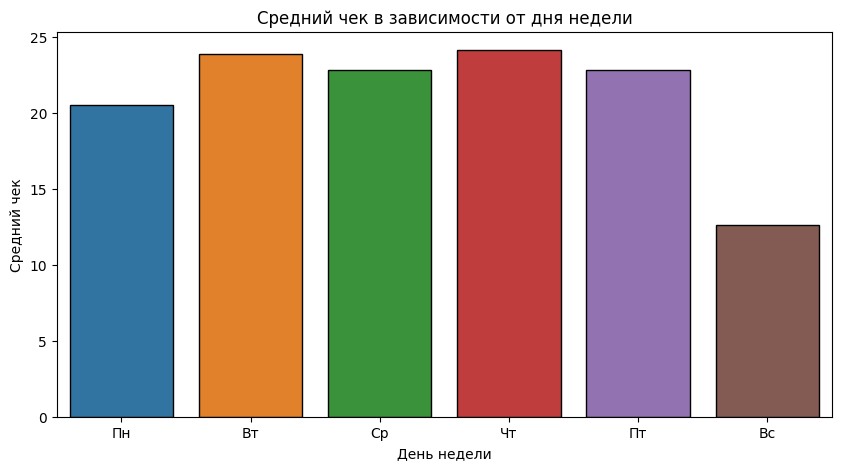

In [5]:
# Группируем данные по дням недели и вычисляем среднюю сумму заказа
dayofweek_sells = df.groupby('DayOfWeek', as_index=False)['TotalPrice'].mean()
# Переименуем дни недели для лучшей интерпретации
day_map = {
    0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт',
    4: 'Пт', 5: 'Сб', 6: 'Вс'
}
dayofweek_sells['DayOfWeek'] = dayofweek_sells['DayOfWeek'].map(day_map)

# Визуализируем зависимость среднего чека от дня недели
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(
    dayofweek_sells,
    x='DayOfWeek',
    y='TotalPrice',
    hue='DayOfWeek'
)

ax.set_title('Средний чек в зависимости от дня недели');
ax.set_xlabel('День недели');
ax.set_ylabel('Средний чек');

Как мы видим, суббота является нерабочим днем данного онлайн-магазина. В основном средний чек составляет выше 20 фунтов, однако в воскресенье он не доходит даже до 15-ти.

Посмотрим на распределение ежедневно поступающих заказов в каждый из часов.

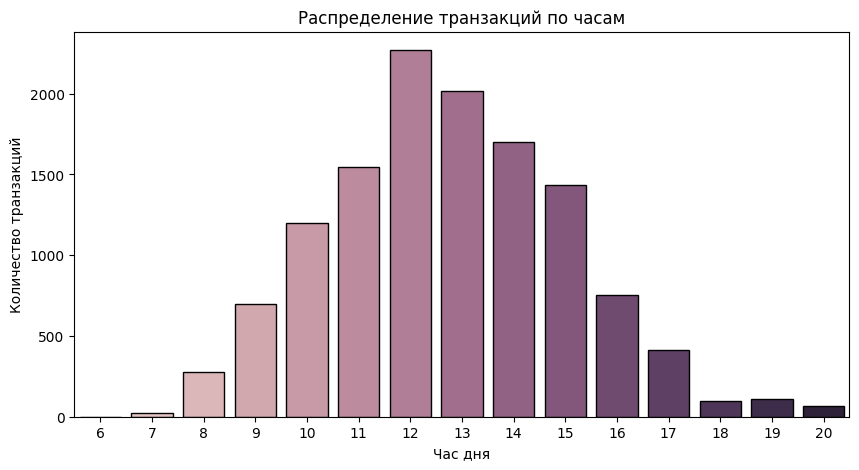

In [6]:
# Группируем транзакции по дате и часу, считаем количество транзакций в каждый час каждого дня
txns_count = df.groupby(['Day', 'Hour'], as_index=False)['InvoiceNo'].count()
# Теперь группируем полученные данные по часу и получаем, сколько заказов в среднем поступает в каждый час суток
hour_mean_txns = txns_count.groupby('Hour', as_index=False)['InvoiceNo'].mean()

# Построим столбчатую диаграмму распределения транзакций по часам
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(hour_mean_txns, x='Hour', y='InvoiceNo', hue='Hour')
ax.set_title('Распределение транзакций по часам');
ax.set_xlabel('Час дня');
ax.set_ylabel('Количество транзакций');
ax.legend_.remove()

Распределение похоже на нормальное, чтобы убедиться в этом, проведем тест Шапиро-Уилка на нормальность.

In [7]:
from scipy.stats import shapiro # импортируем тест Шапиро-Уилка

# Задаем уровень значимости
alpha = 0.05

# Применяем тест Шапиро-Уилка к среднему количеству транзакций по часам)
_, p = shapiro(hour_mean_txns['InvoiceNo'])

if p >= alpha:
    print(f'p-value = {round(p, 4)}, распределение является нормальным')
else:
    print(f'p-value = {round(p, 4)}, распределение не является нормальным')

p-value = 0.0605, распределение является нормальным


### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

In [8]:
# Переведем признак 'InvoiceDate' в формат datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Обозначим точку отсчета
t0 = pd.to_datetime('2011-12-10 00:00:00')

# Группируем данные по клиентам и берём последнюю дату покупки для каждого
recency = df.groupby('CustomerID', as_index=False)['InvoiceDate'].last()
# Вычисляем количество дней с момента последней покупки до заданной даты 't0'.
recency['InvoiceDate'] = (t0 - recency['InvoiceDate']).dt.days

# Группируем данные по клиентам и находим количество уникальных заказов
frequency = df.groupby('CustomerID', as_index=False)['InvoiceDate'].count()

# Группируем данные по клиентам и находим общую сумму денег, потраченную на заказы
monetary_value = df.groupby('CustomerID', as_index=False)['TotalPrice'].sum()

# Объединим полученные таблицы в одну по столбцу 'CustomerID'
rf = pd.merge(recency, frequency, on='CustomerID')
rfm_table = pd.merge(rf, monetary_value, on='CustomerID')
# Переименуем столбцы для лучшей интерпретации
rfm_table.columns = ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']

rfm_table.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12347,2,182,4310.00
1,12348,75,27,1437.24
2,12349,18,72,1457.55
3,12350,310,16,294.40
4,12352,36,70,1265.41


Визуализируем каждую из трёх компонент в виде коробчатых диаграмм.

In [9]:
# Создаём список boxplot-графиков для всех колонок, кроме 'CustomerID'
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns[1:]]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

# Добавляем каждый boxplot в соответствующий subplot
for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.show()

![pic](/pic/rfm.png)

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов, а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95.

In [10]:
# Найдем значения квантилей
frequency_95 = rfm_table['Frequency'].quantile(0.95)
monetary_95 = rfm_table['MonetaryValue'].quantile(0.95)

# Оставим данные, значения которых ниже этих квантилей
rfm_table = rfm_table[(rfm_table['Frequency'] <= frequency_95) &
                      (rfm_table['MonetaryValue'] <= monetary_95)]

# Построим коробчатые диаграммы для обновленных признаков
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns[1:]]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

# Добавляем каждый boxplot в соответствующий subplot
for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.show()

![pic](/pic/rfm95.png)

Отлично, графики стали более компактными и информативными. Удаление верхних выбросов позволило лучше визуализировать основную массу клиентов.

## 3. Моделирование и оценка качества моделей на основе RFM-характеристик

### 3.1. Кластеризация

Для корректной работы алгоритмов кластеризации необходимо привести данные к единому масштабу.

In [11]:
# Импортируем необходимые модули для задачи кластеризации
from sklearn import cluster, metrics, preprocessing, mixture

rfm_table = rfm_table.drop('CustomerID', axis=1) # удалим столбец с клиентами

# Произведем стандартизацию
scaler = preprocessing.StandardScaler()
rfm_std = scaler.fit_transform(rfm_table)

# Преобразуем полученный результат обратно в DataFrame
rfm_std = pd.DataFrame(rfm_std, columns=rfm_table.columns)

rfm_std.head()

,Recency,Frequency,MonetaryValue
0,-0.948779,2.029307,3.244419
1,-0.229869,-0.518921,0.453962
2,-0.791209,0.220887,0.473690
3,2.084429,-0.699763,-0.656136
4,-0.613944,0.188007,0.287055


Произведём кластеризацию клиентов маркетплейса тремя методами: `KMeans`, `EM (Gaussian Mixture)` и `DBSCAN`.

Для каждой из моделей найдём оптимальные параметры с использованием коэффициента силуэта, перебирая возможные значения количества кластеров от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелевантно для маркетинга).

#### 3.1.1. KMeans

In [12]:
def get_silhouette_scores_kmeans(data, cluster_range=(3, 10), random_state=42, n_init=20):
    """
    Вычисляет коэффициенты силуэта для различных значений кластеров при использовании алгоритма KMeans.

    Args:
        data (array-like): Массив или DataFrame со стандартизированными данными.
        cluster_range (tuple): Диапазон количества кластеров (включительно нижняя граница, исключительно верхняя).
        random_state (int): Фиксированное зерно генератора для воспроизводимости.
        n_init (int): Количество инициализаций центроидов при обучении KMeans.

    Returns:
        list: Список коэффициентов силуэта для каждого количества кластеров.
    """
    silhouette_kmeans = []
    
    for n_clusters in range(cluster_range[0], cluster_range[1]):
        model = cluster.KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
        model.fit(data)
        labels = model.labels_
        score = metrics.silhouette_score(data, labels)
        silhouette_kmeans.append(score)
    
    return silhouette_kmeans

silhouette_kmeans = get_silhouette_scores_kmeans(data=rfm_std)

#### 3.1.2. EM-Кластеризация

In [13]:
def get_silhouette_scores_em(data, component_range=(3, 10), random_state=42, n_init=20):
    """
    Вычисляет коэффициенты силуэта для различных количеств компонент в модели Gaussian Mixture.

    Args:
        data (array-like): Массив или DataFrame со стандартизированными данными.
        component_range (tuple): Диапазон количества компонент (включительно нижняя граница, исключительно верхняя).
        random_state (int): Фиксированное зерно генератора для воспроизводимости.
        n_init (int): Количество инициализаций для EM-алгоритма.

    Returns:
        list: Список коэффициентов силуэта для каждой конфигурации компонент.
    """
    silhouette_em = []

    for n_components in range(component_range[0], component_range[1]):
        model = mixture.GaussianMixture(n_components=n_components, n_init=n_init, random_state=random_state)
        labels = model.fit_predict(data)
        score = metrics.silhouette_score(data, labels)
        silhouette_em.append(score)

    return silhouette_em

silhouette_em = get_silhouette_scores_em(data=rfm_std)

#### 3.1.3. DBSCAN

У данного метода кластеризации мы будем подбирать значения `eps` — **радиуса окрестности**, определяющего, на каком расстоянии точки считаются соседями.

В качестве значения `min_samples` воспользуемся **эмпирическим правилом**: min_samples = 2 × n_features

Где:
- `min_samples` — минимальное количество точек в области радиуса `eps`, чтобы точка считалась центральной;
- `n_features` — количество признаков (столбцов) в датасете после стандартизации.

In [14]:
def get_silhouette_dbscan(data, eps_start=0.1, eps_stop=3.0, eps_step=0.1):
    """
    Перебирает значения eps для DBSCAN и возвращает список silhouette_score или None
    в том же порядке, в каком перебираются eps.

    Args:
        data (DataFrame or array-like): массив или DataFrame со стандартизированными данными.
        eps_start (float): начальное значение eps (включительно).
        eps_stop (float): конечное значение eps (не включая).
        eps_step (float): шаг для eps.

    Returns:
        list: silhouette_score или None для каждого eps.
    """
    silhouette_dbscan = []  # пустой список для результатов
    n_features = data.shape[1]  # число признаков

    for eps in np.arange(eps_start, eps_stop, eps_step):
        model_dbscan = cluster.DBSCAN(eps=eps, min_samples=2 * n_features)  # инициализируем модель DBSCAN
        model_dbscan.fit(data)  # обучаем ее

        # Проверка, сколько кластеров (меток) найдено
        unique_labels = np.unique(model_dbscan.labels_)
        if len(unique_labels) > 1:  # проверяем, что есть хотя бы два кластера
            score = metrics.silhouette_score(data, model_dbscan.labels_)
            silhouette_dbscan.append(score)  # сохраняем коэффициент силуэта
        else:
            silhouette_dbscan.append(None)  # если кластеров меньше 2, добавляем None

    return silhouette_dbscan

silhouette_dbscan = get_silhouette_dbscan(data=rfm_std)

#### 3.1.4. Визуализизация коэффициентов силуэта 

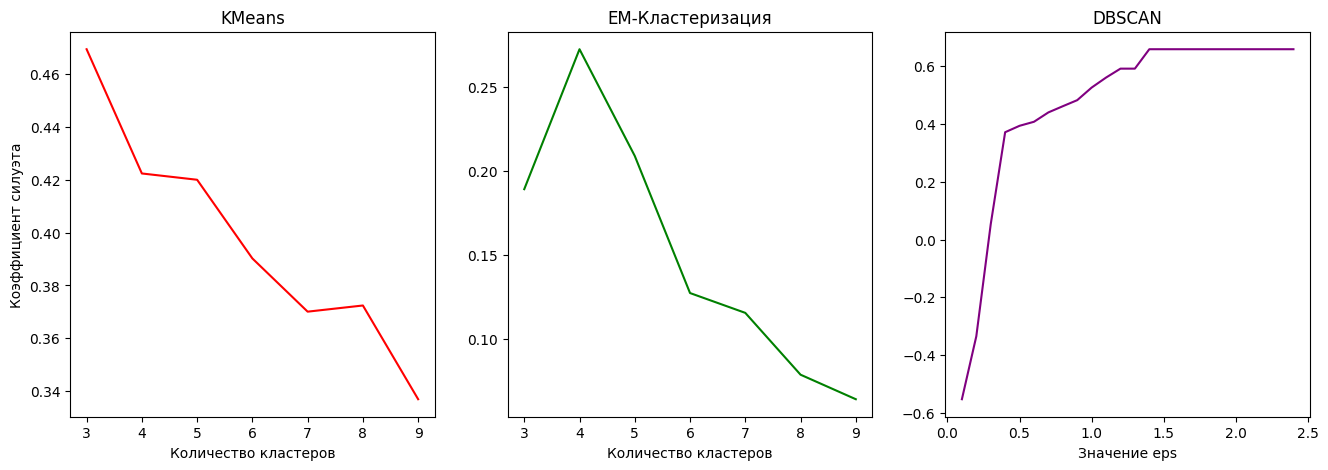

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# KMeans
sns.lineplot(x=range(3, 10), y=silhouette_kmeans, color='red', ax=axes[0])
axes[0].set_title('KMeans');
axes[0].set_xlabel('Количество кластеров');
axes[0].set_ylabel('Коэффициент силуэта');

# EM-Кластеризация
sns.lineplot(x=range(3, 10), y=silhouette_em, color='green', ax=axes[1])
axes[1].set_title('EM-Кластеризация');
axes[1].set_xlabel('Количество кластеров');

# DBSCAN
sns.lineplot(x=np.arange(0.1, 3, 0.1), y=silhouette_dbscan, color='purple', ax=axes[2])
axes[2].set_title('DBSCAN');
axes[2].set_xlabel('Значение eps');

По полученным коэффициентам видим, что хуже всего с этой задачей справилась EM-Кластеризация, поэтому обучим модели KMeans и DBSCAN на лучших параметрах и сравним их кластеры.

In [16]:
# Инициализируем модель KMeans
best_kmeans = cluster.KMeans(n_clusters=3, n_init=20, random_state=42)
# Обучим ее
best_kmeans.fit(rfm_std)
# Добавим столбец с кластерами в нашу RFM-таблицу
rfm_table['KMeans'] = best_kmeans.labels_

# Тоже самое сделаем DBSCAN
best_dbscan = cluster.DBSCAN(eps=1.6, min_samples=2*rfm_std.shape[1])
best_dbscan.fit(rfm_std)
rfm_table['DBSCAN'] = best_dbscan.labels_

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

In [17]:
# Для KMeans
fig = px.scatter_3d(
    rfm_table,
    x='Recency',
    y='Frequency',
    z='MonetaryValue',
    color=rfm_table['KMeans'].astype(str), # для корректного отображения легенды
    title='KMeans',
    width=800,
    height=800
)
# Уменьшим размер точек на графике
fig.update_traces(marker=dict(size=4))
fig.show()

![pic](/pic/kmeans.png)

Кластеризация KMeans показала отличный результат, достаточно четко разделив 3 кластера:

- `0 кластер` - **Обычные клиенты**, которые совершили не так много покупок (*В среднем около 40*) и их чек в основном составлял не более *1500 фунтов*.
- `1 кластер` - **Активные лояльные клиенты**, совершившие много покупок со средним чеком в *2600 фунтов стерлингов*. Именно они приносят основную прибыль маркетплейсу.
- `2 кластер` - **Спящие клиенты**. Те, которые не совершали заказов более *141 дней* и в среднем совершавшие покупки в основном до *1000 фунтов*.

In [18]:
# Для DBSCAN
fig = px.scatter_3d(
    rfm_table,
    x='Recency',
    y='Frequency',
    z='MonetaryValue',
    color=rfm_table['DBSCAN'].astype(str), # для корректного отображения легенды
    title='DBSCAN',
    width=800,
    height=800
)
# Уменьшим размер точек на графике
fig.update_traces(marker=dict(size=4))
fig.show()

![pic](/pic/dbscan.png)

Сразу можно заметить, что данный алгоритм не подходит к нашим данным, не будем его учитывать.

In [19]:
rfm_table.drop('DBSCAN', axis=1, inplace=True)

#### 3.2.2. Построение профиля кластеров

Составим так называемый профиль кластеров. Для этого сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

Для визуализации результатов построим полярную диаграмму.

In [20]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

In [21]:
# Сгруппируем данные по кластерам и рассчитаем среднее по каждому признаку
grouped_data = rfm_table.groupby('KMeans')[['Recency', 'Frequency', 'MonetaryValue']].mean()

plot_cluster_profile(grouped_data, 3)

![pic](/pic/polar.png)

Как было указано выше, данные четко были разделены между 3-мя кластерами:
- `Обычные клиенты (0 кластер)` - умеренные значения по всем признакам.
- `Активные клиенты (1 кластер)` - максимальные значения по Frequency и MonetaryValue.
- `Спящие клиенты (2 кластер)` - максимальные значения по Recency.

## 4. Применение методов снижения размерности для выявления кластеров

Получив обратную связь о проделанной работе, выяснилось, что 3-х групп клиентов недостаточно. Для более точной кластеризации и качественного анализа структуры клиентской базы важно не только использовать агрегированные признаки (такие как RFM), но и глубже понять распределение данных в пространстве. Однако трехмерного представления (RFM) может оказаться недостаточно, особенно если данные содержат нелинейные зависимости или скрытые взаимосвязи между объектами.

### 4.1. Понижение размерности T-SNE

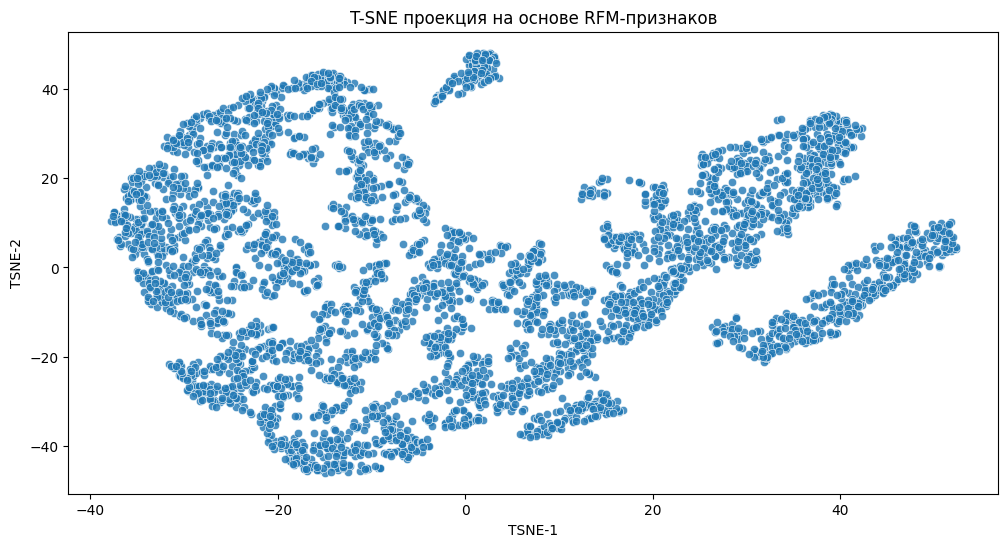

In [51]:
from sklearn.manifold import TSNE

# Применяем T-SNE к стандартизованным данным
tsne = TSNE(n_components=2, perplexity=60, random_state=42)
tsne_results = tsne.fit_transform(rfm_std)

# Преобразуем результаты в DataFrame
tsne_df = pd.DataFrame()
tsne_df['TSNE-1'] = tsne_results[:, 0]
tsne_df['TSNE-2'] = tsne_results[:, 1]

# Визуализация
fig = plt.figure(figsize=(12, 6))
ax = sns.scatterplot(tsne_df, x='TSNE-1', y='TSNE-2', alpha=0.8)
ax.set_title('T-SNE проекция на основе RFM-признаков');

### 4.2. Построение моделей.

Для каждой модели найдем оптимальные параметры, как делали это ранее

#### 4.2.1. KMeans

In [52]:
silhouette_kmeans_tsne = get_silhouette_scores_kmeans(data=tsne_df, cluster_range=(4, 10))

#### 4.2.2. EM-Кластеризация

In [53]:
silhouette_em_tsne = get_silhouette_scores_em(data=tsne_df, component_range=(4, 10))

#### 4.2.3. DBSCAN

In [54]:
silhouette_dbscan_tsne = get_silhouette_dbscan(data=tsne_df)

#### 4.2.4. Визуализация коэффициентов силуэта

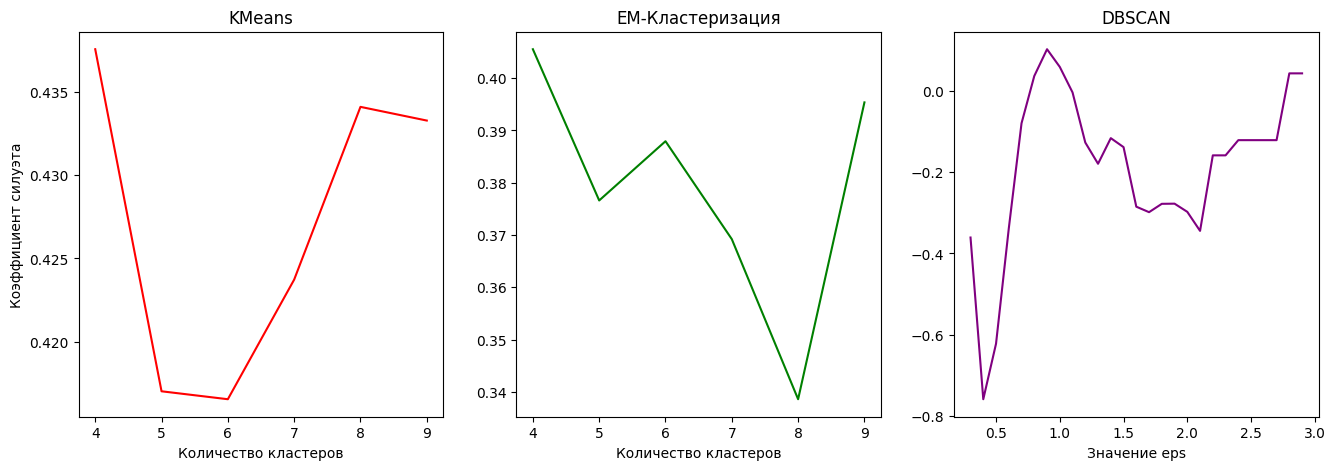

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# KMeans
sns.lineplot(x=range(4, 10), y=silhouette_kmeans_tsne, color='red', ax=axes[0])
axes[0].set_title('KMeans');
axes[0].set_xlabel('Количество кластеров');
axes[0].set_ylabel('Коэффициент силуэта');

# EM-Кластеризация
sns.lineplot(x=range(4, 10), y=silhouette_em_tsne, color='green', ax=axes[1])
axes[1].set_title('EM-Кластеризация');
axes[1].set_xlabel('Количество кластеров');

# DBSCAN
sns.lineplot(x=np.arange(0.1, 3, 0.1), y=silhouette_dbscan_tsne, color='purple', ax=axes[2])
axes[2].set_title('DBSCAN');
axes[2].set_xlabel('Значение eps');

Видим, что наибольший коэффициент силуэта прихоится на модель KMeans. Несмотря на то, что у *4-х кластеров* коэффициент выше, мы возьмем другой пик (*8 кластеров*), так как *4 кластера* недостаточно.

In [56]:
# Инициализируем модель KMeans
best_kmeans_tsne = cluster.KMeans(n_clusters=8, n_init=20, random_state=42)
# Обучим ее
best_kmeans_tsne.fit(tsne_df)
# Добавим столбец с кластерами в нашу RFM-таблицу
tsne_df['KMeans'] = best_kmeans_tsne.labels_
rfm_table['KMeans_tsne'] = best_kmeans_tsne.labels_ # для дальнейшей визуализации профиля кластеров

### 4.3. Визуализация полученных кластеров

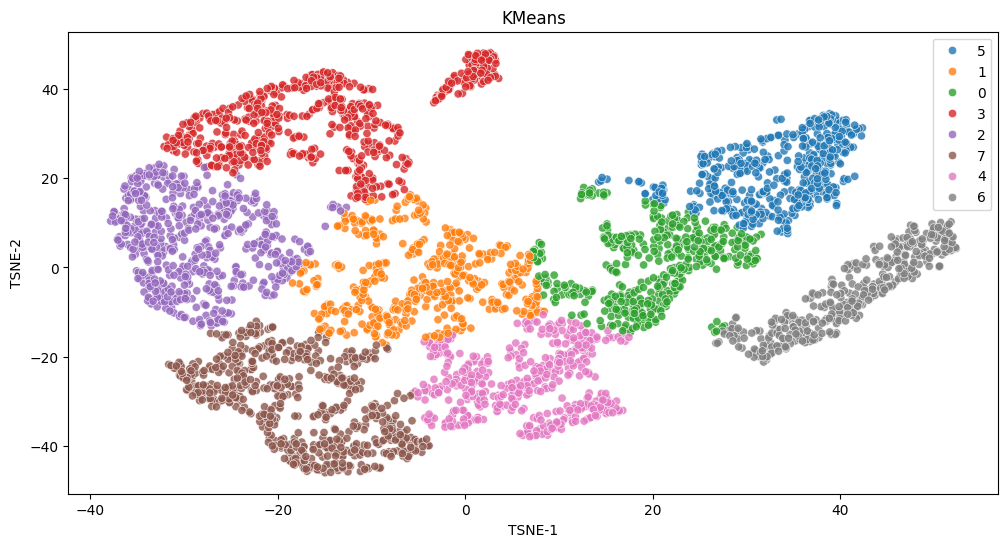

In [58]:
# KMeans
fig = plt.figure(figsize=(12, 6))
ax = sns.scatterplot(tsne_df, x='TSNE-1', y='TSNE-2', hue=best_kmeans_tsne.labels_.astype(str), alpha=0.8)
ax.set_title('KMeans');

#### 4.3.1. Профиль кластеров.

In [60]:
# Профиль кластеров KMeans
grouped_tsne_kmeans = rfm_table.groupby('KMeans_tsne')[['Recency', 'Frequency', 'MonetaryValue']].mean()
plot_cluster_profile(grouped_tsne_kmeans, 8)

![pic](/pic/polar_tsne.png)

In [ ]:
# Выведем средние значения по кластерам
display(grouped_tsne_kmeans)

,Recency,Frequency,MonetaryValue
KMeans_tsne,,,
0,30.237875,77.847575,1550.028476
1,90.136461,49.609808,959.865394
2,160.911032,18.829181,344.042811
3,291.971383,23.203498,390.982130
4,21.965909,38.859091,564.991455
5,33.155702,145.098684,3272.755439
6,30.371429,155.023377,1067.614727
7,43.571429,14.417335,263.274077


Данные хорошо разделились на 8 кластеров, каждый из которых отражает разные типы клиентов: есть те, кто покупает часто и много, а есть те, кто делает заказы редко или давно не проявлял активности. Такое разделение помогает лучше понять поведение пользователей и выстроить подход к каждому сегменту.

## 5. Вывод

В рамках проекта был проведён анализ поведения клиентов на основе RFM-модели. Для этого:

- Данные были дополнены новыми признаками.

- Проведено сравнение различных методов кластеризации, таких как `KMeans`, `DBSCAN` и `EM (Gaussian Mixture)`.

- Для улучшения качества кластеризации применен метод понижения размерности `T-SNE`.

- Построены визуализации и профили кластеров, что позволило выделить ключевые сегменты клиентов.

Наилучшие результаты показал алгоритм KMeans, который позволил разделить клиентов на 8 кластеров, отражающих разные типы поведения:

- `Кластер 0` — **Лояльные активные клиенты**. \
Совершают покупки регулярно и недавно, обеспечивая стабильную выручку. \
(Recency — 30, Frequency — 78, MonetaryValue — 1550)

- `Кластер 1` — **Обычные клиенты**. \
Средние значения всех показателей. Потенциально можно повысить вовлечённость. \
(Recency — 90, Frequency — 49, MonetaryValue — 960)

- `Кластер 2` — **Спящие клиенты**. \
Давно не делали покупок и редко активны. Можно попытаться реактивировать. \
(Recency — 160, Frequency — 18, MonetaryValue — 344)

- `Кластер 3` — **Потерянные клиенты**. \
Очень давно не активны, редко совершают покупки. Малоперспективны. \
(Recency — 292, Frequency — 23, MonetaryValue — 391)

- `Кластер 4` — **Новые перспективные клиенты**. \
Недавно пришли, умеренно активны. Есть потенциал для роста. \
(Recency — 22, Frequency — 39, MonetaryValue — 565)

- `Кластер 5` — **Премиум-клиенты**. \
Самые частые и щедрые покупатели. Основной источник прибыли. \
(Recency — 33, Frequency — 145, MonetaryValue — 3273)

- `Кластер 6` — **Частые, но экономные клиенты**. \
Высокая активность, но средний чек ниже. Можно стимулировать рост затрат. \
(Recency — 30, Frequency — 155, MonetaryValue — 1068)

- `Кластер 7` — **Редкие клиенты с низкой прибылью**. \
Низкая вовлечённость и вклад в выручку. \
(Recency — 44, Frequency — 14, MonetaryValue — 263)